# Stock Price Indicator
                
## Project aims to predict adjusted close price of some stocks chosen previously.


## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values


In [1]:
#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

adjclose = 'Adj Close'

stock_list = ['AAPL', 'AMZN', 'AVGO', 'CSCO', 'MA', 'MSFT', 'NVDA', 'NVS', 'PFE', 'QCOM', 'TXN', 'V', 'WMT']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2019,3,19)

#for stock in stock_list:
    #history = pdr.get_data_yahoo(stock, start, end)
    #history.to_csv('./data1/'+stock+'.csv')

AMZN = pd.read_csv('data/AMZN.csv', header=0, parse_dates=['Date'])
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,130.960007,128.639999,130.199997,130.470001,5383400,130.470001
1,2010-03-23,130.940002,128.070007,130.889999,129.259995,4213100,129.259995
2,2010-03-24,129.399994,127.199997,128.639999,128.039993,4696400,128.039993
3,2010-03-25,136.910004,128.039993,129.139999,134.729996,16209600,134.729996
4,2010-03-26,136.990005,133.759995,134.899994,135.059998,6565700,135.059998


In [2]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data[adjclose].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



In [3]:
# C- check for null values

for stock_data in stock_data_list:
    print(stock_data.isnull().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False


## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [4]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe[adjclose].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe[adjclose].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column=adjclose, period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column=adjclose, period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df[adjclose].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,adjclose, 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data = stock_data[25:] #delete NaN values
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


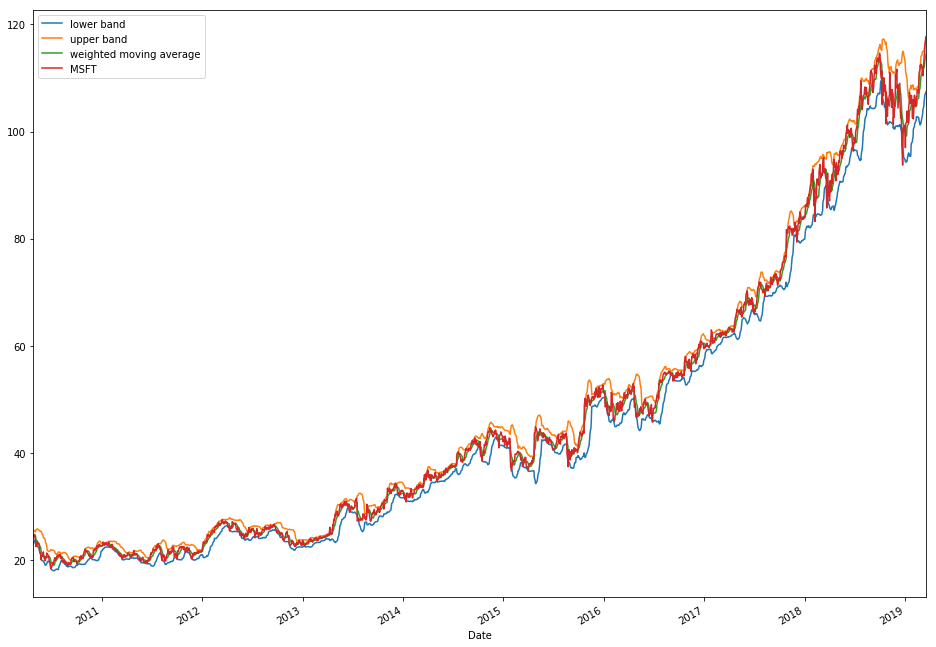

In [5]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data[adjclose].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization & Seperation

In [6]:
from sklearn import preprocessing

normalized_stock_list = []
y_adj_close_list = []
scaler = preprocessing.MinMaxScaler()


for stock_data in stock_data_list:
    stock_data = stock_data.drop(columns='stock_name')
   
    names = stock_data.columns
    scaled_df = scaler.fit_transform(stock_data)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    #scale adjusted price to 100
    scaled_df[adjclose] = scaled_df[adjclose].apply(lambda x: x*100)

    
    y_adj_close_list.append(scaled_df[adjclose])
    scaled_df = scaled_df.drop(columns=adjclose)
    
    normalized_stock_list.append(scaled_df)

#since we want n+1 adj close price to be predicted with the n th day values
#we need to shift y values for 1 day 
for y_adj_close in y_adj_close_list:
    y_adj_close.shift(-1)




    
print(y_adj_close_list[5]) # our target list to predict  
print(normalized_stock_list[5]) # our input values for models  
   


0         6.232732
1         6.281071
2         6.353582
3         5.982979
4         6.240790
5         5.652660
6         5.427072
7         4.726149
8         4.105787
9         4.693921
10        4.645576
11        5.096754
12        4.935621
13        4.685865
14        4.693921
15        4.523967
16        4.232612
17        3.318116
18        3.099600
19        2.638310
20        2.476448
21        1.618589
22        2.419793
23        2.257935
24        2.330771
25        2.792076
26        3.115788
27        2.249843
28        1.845195
29        1.699525
           ...    
2209     89.024115
2210     87.829382
2211     87.066355
2212     87.467954
2213     87.046286
2214     88.692802
2215     88.612478
2216     88.702841
2217     90.028084
2218     89.977883
2219     89.413259
2220     91.691931
2221     93.264816
2222     93.889933
2223     94.666298
2224     94.474726
2225     94.333570
2226     94.837701
2227     94.565474
2228     94.000842
2229     94.051258
2230     92.

/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: RMSE and R2 Validation
### C: Solution Model
### D: Test Flow


In [7]:
# A- For Benchmark we will use standard linear regression
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers, optimizers
from sklearn.model_selection import train_test_split

from pylab import *


def create_benchmark_model():
   model = Sequential()
   model.add(Dense(1, activation = 'linear', input_dim = 10))
   sgd = optimizers.SGD(lr=0.2)
   model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['accuracy'])
   return model

# B - RMSE Score, R2 Score
from sklearn.metrics import mean_squared_error, r2_score


def RMSE_score(y, y_predicted, method_name):
    RMSE_score = np.sqrt(mean_squared_error(y, y_predicted))
    print(method_name + " RMSE Score: {0}".format(RMSE_score))
    return RMSE_score


def R2_score(y, y_predicted, method_name):
    R2_score = r2_score(y, y_predicted)
    print( method_name +" R2 Score: {0}".format(R2_score))
    return R2_score

def check_score(y, y_predicted, method_name):
    rmse = RMSE_score(y, y_predicted, method_name)
    r2 = R2_score(y, y_predicted, method_name)
    return rmse, r2


Using TensorFlow backend.


In [8]:
# C - Solution Models LSTM and SVM 
from sklearn import svm
from keras.layers.recurrent import LSTM
from keras.layers import Dropout, Activation, Flatten
import numpy 

def create_svm_linear_model():
    model = svm.SVR(kernel='linear', C=100)
    return model

def create_svm_polynomial_model():
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    return model

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(1, 10), units=100, dropout=0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model
       

In [9]:
#D -Test Flow

def drive_test(use_different_models):
    results_dataframe = pd.DataFrame()
    linear_reg_predictions = []
    svm_linear_predictions = []
    svm_poly_predictions = []
    lstm_predictions = []
    y_actuals = []
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #create models
        if (use_different_models or index == 0):
            linear_regression_model = create_benchmark_model() 
            svm_linear = create_svm_linear_model()
            svm_polynomial = create_svm_polynomial_model()
            lstm_model = create_lstm_model()
        linear_regression_model = create_benchmark_model() 
        svm_linear = create_svm_linear_model()
        svm_polynomial = create_svm_polynomial_model()
        lstm_model = create_lstm_model()
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)

        linear_regression_model.fit(X_train, y_train, epochs =10,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)
        linear_reg_predictions.append(linear_y_predict)


        svm_linear.fit(X_train, y_train)
        svm_linear_y_predict = svm_linear.predict(X_test)
        svm_linear_predictions.append(svm_linear_y_predict)


        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)
        svm_poly_predictions.append(svm_polynomial_y_predict)

        trainX = numpy.reshape(X_train.values, (X_train.shape[0],1, -1))
        testX = numpy.reshape(X_test.values, (X_test.shape[0],1, X_test.shape[1]))
        lstm_model.fit(trainX, y_train, batch_size =32,epochs = 100)
        lstm_y_predict = lstm_model.predict(testX)
        lstm_predictions.append(lstm_y_predict)


        rmse_1, r2_1 = check_score(y_test, linear_y_predict, "Linear Regression")
        rmse_2, r2_2 = check_score(y_test, svm_linear_y_predict, "SVM Linear Model")
        rmse_3, r2_3 = check_score(y_test, svm_polynomial_y_predict, "SVM Polynomial Model")
        rmse_4, r2_4 = check_score(y_test, lstm_y_predict, "LSTM Model")

        print(index )

        df = pd.DataFrame({"linear_rmse": rmse_1,  "linear_r2": r2_1, 
                                   "svm_linear_rmse":rmse_2, "svm_linear_r2":r2_2,
                                   "svm_polynomial_rmse":rmse_3, "svm_polynomial_r2":r2_3,
                                   "lstm_rmse":rmse_4, "lstm_r2":r2_4 }, index=[index])

        results_dataframe = results_dataframe.append(df)
        y_actuals.append(y_test)
    return results_dataframe, linear_reg_predictions, svm_linear_predictions, \
                svm_poly_predictions, lstm_predictions, y_actuals

In [10]:
results_different_models , linear_reg_predictions, svm_linear_predictions, \
svm_poly_predictions, lstm_predictions, y_actuals = drive_test(True)
result_same_models, a,b,c,d,e= drive_test(False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1791/1791 [==============================] - 0s 79us/step - loss: 47.2210 - acc: 0.0000e+00
Epoch 2/10
1791/1791 [==============================] - 0s 11us/step - loss: 1.9942 - acc: 0.0000e+00
Epoch 3/10
1791/1791 [==============================] - 0s 11us/step - loss: 1.9336 - acc: 0.0000e+00
Epoch 4/10
1791/1791 [==============================] - 0s 13us/step - loss: 1.8756 - acc: 0.0000e+00
Epoch 5/10
1791/1791 [==============================] - 0s 11us/step - loss: 1.8353 - acc: 0.0000e+00
Epoch 6/10
1791/1791 [==============================] - 0s 11us/step - loss: 1.7989 - acc: 5.5835e-04
Epoch 7/10
1791/1791 [==============================] - 0s 11us/step - loss: 1.7472 - acc: 0.0000e+00
Epoch 8/10
1791/1791 [============================

1791/1791 [==============================] - 0s 33us/step - loss: 27.5241
Epoch 73/100
1791/1791 [==============================] - 0s 33us/step - loss: 26.8786
Epoch 74/100
1791/1791 [==============================] - 0s 33us/step - loss: 24.6927
Epoch 75/100
1791/1791 [==============================] - 0s 32us/step - loss: 25.8858
Epoch 76/100
1791/1791 [==============================] - 0s 32us/step - loss: 24.7517
Epoch 77/100
1791/1791 [==============================] - 0s 33us/step - loss: 26.7896
Epoch 78/100
1791/1791 [==============================] - 0s 32us/step - loss: 25.9007
Epoch 79/100
1791/1791 [==============================] - 0s 33us/step - loss: 26.5627
Epoch 80/100
1791/1791 [==============================] - 0s 33us/step - loss: 28.0478
Epoch 81/100
1791/1791 [==============================] - 0s 32us/step - loss: 27.9589
Epoch 82/100
1791/1791 [==============================] - 0s 33us/step - loss: 28.6243
Epoch 83/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 34us/step - loss: 18.4751
Epoch 51/100
1791/1791 [==============================] - 0s 34us/step - loss: 17.9073
Epoch 52/100
1791/1791 [==============================] - 0s 34us/step - loss: 16.7882
Epoch 53/100
1791/1791 [==============================] - 0s 34us/step - loss: 17.4977
Epoch 54/100
1791/1791 [==============================] - 0s 34us/step - loss: 16.7867
Epoch 55/100
1791/1791 [==============================] - 0s 34us/step - loss: 18.4141
Epoch 56/100
1791/1791 [==============================] - 0s 34us/step - loss: 18.4605
Epoch 57/100
1791/1791 [==============================] - 0s 33us/step - loss: 20.5579
Epoch 58/100
1791/1791 [==============================] - 0s 34us/step - loss: 17.1720
Epoch 59/100
1791/1791 [==============================] - 0s 34us/step - loss: 18.9057
Epoch 60/100
1791/1791 [==============================] - 0s 34us/step - loss: 17.0774
Epoch 61/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 33us/step - loss: 24.4456
Epoch 29/100
1791/1791 [==============================] - 0s 34us/step - loss: 24.4397
Epoch 30/100
1791/1791 [==============================] - 0s 34us/step - loss: 25.0700
Epoch 31/100
1791/1791 [==============================] - 0s 33us/step - loss: 25.8548
Epoch 32/100
1791/1791 [==============================] - 0s 34us/step - loss: 25.2248
Epoch 33/100
1791/1791 [==============================] - 0s 33us/step - loss: 26.2517
Epoch 34/100
1791/1791 [==============================] - 0s 33us/step - loss: 26.3788
Epoch 35/100
1791/1791 [==============================] - 0s 35us/step - loss: 25.2538
Epoch 36/100
1791/1791 [==============================] - 0s 34us/step - loss: 22.4791
Epoch 37/100
1791/1791 [==============================] - 0s 33us/step - loss: 24.7892
Epoch 38/100
1791/1791 [==============================] - 0s 34us/step - loss: 27.7156
Epoch 39/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 34us/step - loss: 448.3561
Epoch 7/100
1791/1791 [==============================] - 0s 34us/step - loss: 330.7148
Epoch 8/100
1791/1791 [==============================] - 0s 33us/step - loss: 260.4262
Epoch 9/100
1791/1791 [==============================] - 0s 34us/step - loss: 213.0760
Epoch 10/100
1791/1791 [==============================] - 0s 34us/step - loss: 169.8486
Epoch 11/100
1791/1791 [==============================] - 0s 34us/step - loss: 134.2809
Epoch 12/100
1791/1791 [==============================] - 0s 34us/step - loss: 102.4215
Epoch 13/100
1791/1791 [==============================] - 0s 34us/step - loss: 80.9861
Epoch 14/100
1791/1791 [==============================] - 0s 34us/step - loss: 63.7556
Epoch 15/100
1791/1791 [==============================] - 0s 34us/step - loss: 54.4859
Epoch 16/100
1791/1791 [==============================] - 0s 34us/step - loss: 41.0528
Epoch 17/100
1791/1791 [============================

1791/1791 [==============================] - 0s 35us/step - loss: 22.3794
Linear Regression RMSE Score: 0.9582838671890893
Linear Regression R2 Score: 0.9981195841418266
SVM Linear Model RMSE Score: 0.7603262240992569
SVM Linear Model R2 Score: 0.9988162350111622
SVM Polynomial Model RMSE Score: 0.4520705408346115
SVM Polynomial Model R2 Score: 0.9995815168598883
LSTM Model RMSE Score: 1.6890756423606228
LSTM Model R2 Score: 0.9941579704452596
3
Epoch 1/10
1791/1791 [==============================] - 0s 256us/step - loss: 61.5054 - acc: 0.0000e+00
Epoch 2/10
1791/1791 [==============================] - 0s 12us/step - loss: 0.2632 - acc: 0.0011
Epoch 3/10
1791/1791 [==============================] - 0s 13us/step - loss: 0.2597 - acc: 5.5835e-04
Epoch 4/10
1791/1791 [==============================] - 0s 13us/step - loss: 0.2517 - acc: 0.0011
Epoch 5/10
1791/1791 [==============================] - 0s 13us/step - loss: 0.2470 - acc: 5.5835e-04
Epoch 6/10
1791/1791 [========================

1791/1791 [==============================] - 0s 35us/step - loss: 23.0488
Epoch 79/100
1791/1791 [==============================] - 0s 36us/step - loss: 21.6337
Epoch 80/100
1791/1791 [==============================] - 0s 35us/step - loss: 23.3676
Epoch 81/100
1791/1791 [==============================] - 0s 35us/step - loss: 21.1559
Epoch 82/100
1791/1791 [==============================] - 0s 36us/step - loss: 24.4885
Epoch 83/100
1791/1791 [==============================] - 0s 35us/step - loss: 22.9666
Epoch 84/100
1791/1791 [==============================] - 0s 35us/step - loss: 20.3010
Epoch 85/100
1791/1791 [==============================] - 0s 35us/step - loss: 22.7021
Epoch 86/100
1791/1791 [==============================] - 0s 35us/step - loss: 22.5888
Epoch 87/100
1791/1791 [==============================] - 0s 34us/step - loss: 21.6838
Epoch 88/100
1791/1791 [==============================] - 0s 36us/step - loss: 20.9089
Epoch 89/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 35us/step - loss: 19.4420
Epoch 57/100
1791/1791 [==============================] - 0s 35us/step - loss: 21.3584
Epoch 58/100
1791/1791 [==============================] - 0s 36us/step - loss: 20.9467
Epoch 59/100
1791/1791 [==============================] - 0s 36us/step - loss: 20.0050
Epoch 60/100
1791/1791 [==============================] - 0s 36us/step - loss: 20.1294
Epoch 61/100
1791/1791 [==============================] - 0s 36us/step - loss: 18.6565
Epoch 62/100
1791/1791 [==============================] - 0s 35us/step - loss: 18.7323
Epoch 63/100
1791/1791 [==============================] - 0s 36us/step - loss: 19.8998
Epoch 64/100
1791/1791 [==============================] - 0s 35us/step - loss: 21.3630
Epoch 65/100
1791/1791 [==============================] - 0s 36us/step - loss: 20.1992
Epoch 66/100
1791/1791 [==============================] - 0s 37us/step - loss: 22.0093
Epoch 67/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 36us/step - loss: 14.0025
Epoch 35/100
1791/1791 [==============================] - 0s 36us/step - loss: 17.6417
Epoch 36/100
1791/1791 [==============================] - 0s 35us/step - loss: 14.8873
Epoch 37/100
1791/1791 [==============================] - 0s 36us/step - loss: 14.2801
Epoch 38/100
1791/1791 [==============================] - 0s 36us/step - loss: 15.8259
Epoch 39/100
1791/1791 [==============================] - 0s 36us/step - loss: 15.2213
Epoch 40/100
1791/1791 [==============================] - 0s 35us/step - loss: 15.7344
Epoch 41/100
1791/1791 [==============================] - 0s 35us/step - loss: 17.2022
Epoch 42/100
1791/1791 [==============================] - 0s 37us/step - loss: 14.9794
Epoch 43/100
1791/1791 [==============================] - 0s 36us/step - loss: 17.8678
Epoch 44/100
1791/1791 [==============================] - 0s 35us/step - loss: 16.5720
Epoch 45/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 36us/step - loss: 251.7181
Epoch 13/100
1791/1791 [==============================] - 0s 36us/step - loss: 189.7439
Epoch 14/100
1791/1791 [==============================] - 0s 36us/step - loss: 139.6864
Epoch 15/100
1791/1791 [==============================] - 0s 37us/step - loss: 109.0053
Epoch 16/100
1791/1791 [==============================] - 0s 36us/step - loss: 83.5491
Epoch 17/100
1791/1791 [==============================] - 0s 38us/step - loss: 74.0603
Epoch 18/100
1791/1791 [==============================] - 0s 35us/step - loss: 67.9449
Epoch 19/100
1791/1791 [==============================] - 0s 36us/step - loss: 58.3210
Epoch 20/100
1791/1791 [==============================] - 0s 37us/step - loss: 55.3570
Epoch 21/100
1791/1791 [==============================] - 0s 36us/step - loss: 56.8231
Epoch 22/100
1791/1791 [==============================] - 0s 36us/step - loss: 52.2063
Epoch 23/100
1791/1791 [============================

1791/1791 [==============================] - 1s 484us/step - loss: 73.9234 - acc: 0.0000e+00
Epoch 2/10
1791/1791 [==============================] - 0s 15us/step - loss: 3.3164 - acc: 0.0000e+00
Epoch 3/10
1791/1791 [==============================] - 0s 15us/step - loss: 2.9922 - acc: 0.0000e+00
Epoch 4/10
1791/1791 [==============================] - 0s 14us/step - loss: 3.2132 - acc: 0.0000e+00
Epoch 5/10
1791/1791 [==============================] - 0s 14us/step - loss: 2.7312 - acc: 0.0000e+00
Epoch 6/10
1791/1791 [==============================] - 0s 15us/step - loss: 2.5446 - acc: 0.0000e+00
Epoch 7/10
1791/1791 [==============================] - 0s 14us/step - loss: 2.4055 - acc: 0.0000e+00
Epoch 8/10
1791/1791 [==============================] - 0s 14us/step - loss: 2.2313 - acc: 0.0000e+00
Epoch 9/10
1791/1791 [==============================] - 0s 14us/step - loss: 2.0934 - acc: 0.0000e+00
Epoch 10/10
1791/1791 [==============================] - 0s 14us/step - loss: 1.9733 - acc:

1791/1791 [==============================] - 0s 37us/step - loss: 43.4428
Epoch 84/100
1791/1791 [==============================] - 0s 37us/step - loss: 37.3988
Epoch 85/100
1791/1791 [==============================] - 0s 36us/step - loss: 37.3108
Epoch 86/100
1791/1791 [==============================] - 0s 37us/step - loss: 39.7475
Epoch 87/100
1791/1791 [==============================] - 0s 36us/step - loss: 37.3951
Epoch 88/100
1791/1791 [==============================] - 0s 36us/step - loss: 39.4007
Epoch 89/100
1791/1791 [==============================] - 0s 38us/step - loss: 39.9798
Epoch 90/100
1791/1791 [==============================] - 0s 36us/step - loss: 38.3454
Epoch 91/100
1791/1791 [==============================] - 0s 36us/step - loss: 39.6561
Epoch 92/100
1791/1791 [==============================] - 0s 36us/step - loss: 37.8039
Epoch 93/100
1791/1791 [==============================] - 0s 36us/step - loss: 41.1577
Epoch 94/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 38us/step - loss: 54.7688
Epoch 62/100
1791/1791 [==============================] - 0s 40us/step - loss: 53.7156
Epoch 63/100
1791/1791 [==============================] - 0s 37us/step - loss: 52.5595
Epoch 64/100
1791/1791 [==============================] - 0s 38us/step - loss: 54.2157
Epoch 65/100
1791/1791 [==============================] - 0s 36us/step - loss: 55.9281
Epoch 66/100
1791/1791 [==============================] - 0s 37us/step - loss: 55.2532
Epoch 67/100
1791/1791 [==============================] - 0s 37us/step - loss: 56.6936
Epoch 68/100
1791/1791 [==============================] - 0s 37us/step - loss: 55.2755
Epoch 69/100
1791/1791 [==============================] - 0s 37us/step - loss: 52.2384
Epoch 70/100
1791/1791 [==============================] - 0s 38us/step - loss: 51.5280
Epoch 71/100
1791/1791 [==============================] - 0s 37us/step - loss: 52.6900
Epoch 72/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 37us/step - loss: 27.8752
Epoch 40/100
1791/1791 [==============================] - 0s 39us/step - loss: 25.5534
Epoch 41/100
1791/1791 [==============================] - 0s 37us/step - loss: 26.0234
Epoch 42/100
1791/1791 [==============================] - 0s 37us/step - loss: 27.9352
Epoch 43/100
1791/1791 [==============================] - 0s 38us/step - loss: 25.2860
Epoch 44/100
1791/1791 [==============================] - 0s 37us/step - loss: 26.0385
Epoch 45/100
1791/1791 [==============================] - 0s 38us/step - loss: 27.1072
Epoch 46/100
1791/1791 [==============================] - 0s 39us/step - loss: 26.2522
Epoch 47/100
1791/1791 [==============================] - 0s 37us/step - loss: 27.3219
Epoch 48/100
1791/1791 [==============================] - 0s 39us/step - loss: 24.9831
Epoch 49/100
1791/1791 [==============================] - 0s 37us/step - loss: 24.1335
Epoch 50/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 40us/step - loss: 50.4799
Epoch 18/100
1791/1791 [==============================] - 0s 37us/step - loss: 42.2690
Epoch 19/100
1791/1791 [==============================] - 0s 38us/step - loss: 38.2690
Epoch 20/100
1791/1791 [==============================] - 0s 38us/step - loss: 31.8936
Epoch 21/100
1791/1791 [==============================] - 0s 38us/step - loss: 32.5427
Epoch 22/100
1791/1791 [==============================] - 0s 37us/step - loss: 29.7012
Epoch 23/100
1791/1791 [==============================] - 0s 38us/step - loss: 30.4750
Epoch 24/100
1791/1791 [==============================] - 0s 38us/step - loss: 28.8213
Epoch 25/100
1791/1791 [==============================] - 0s 39us/step - loss: 29.4845
Epoch 26/100
1791/1791 [==============================] - 0s 39us/step - loss: 28.3273
Epoch 27/100
1791/1791 [==============================] - 0s 38us/step - loss: 29.3370
Epoch 28/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 16us/step - loss: 3.1909 - acc: 0.0000e+00
Epoch 7/10
1791/1791 [==============================] - 0s 16us/step - loss: 3.0045 - acc: 0.0000e+00
Epoch 8/10
1791/1791 [==============================] - 0s 16us/step - loss: 2.8255 - acc: 0.0000e+00
Epoch 9/10
1791/1791 [==============================] - 0s 15us/step - loss: 2.6243 - acc: 0.0000e+00
Epoch 10/10
1791/1791 [==============================] - 0s 16us/step - loss: 2.4449 - acc: 5.5835e-04
Epoch 1/100
1791/1791 [==============================] - 2s 868us/step - loss: 2030.5509
Epoch 2/100
1791/1791 [==============================] - 0s 40us/step - loss: 1812.9739
Epoch 3/100
1791/1791 [==============================] - 0s 39us/step - loss: 1520.0644
Epoch 4/100
1791/1791 [==============================] - 0s 39us/step - loss: 1201.0257
Epoch 5/100
1791/1791 [==============================] - 0s 37us/step - loss: 895.9357
Epoch 6/100
1791/1791 [==============================] - 0s 

1791/1791 [==============================] - 0s 38us/step - loss: 33.2875
Epoch 90/100
1791/1791 [==============================] - 0s 37us/step - loss: 34.1772
Epoch 91/100
1791/1791 [==============================] - 0s 38us/step - loss: 33.8498
Epoch 92/100
1791/1791 [==============================] - 0s 37us/step - loss: 35.4049
Epoch 93/100
1791/1791 [==============================] - 0s 37us/step - loss: 33.7369
Epoch 94/100
1791/1791 [==============================] - 0s 39us/step - loss: 32.0266
Epoch 95/100
1791/1791 [==============================] - 0s 38us/step - loss: 34.6442
Epoch 96/100
1791/1791 [==============================] - 0s 38us/step - loss: 33.5435
Epoch 97/100
1791/1791 [==============================] - 0s 37us/step - loss: 33.7726
Epoch 98/100
1791/1791 [==============================] - 0s 37us/step - loss: 33.0080
Epoch 99/100
1791/1791 [==============================] - 0s 38us/step - loss: 35.7150
Epoch 100/100
1791/1791 [==============================]

1791/1791 [==============================] - 0s 41us/step - loss: 25.7044
Epoch 68/100
1791/1791 [==============================] - 0s 39us/step - loss: 27.5041
Epoch 69/100
1791/1791 [==============================] - 0s 39us/step - loss: 26.1905
Epoch 70/100
1791/1791 [==============================] - 0s 38us/step - loss: 26.5563
Epoch 71/100
1791/1791 [==============================] - 0s 39us/step - loss: 23.6269
Epoch 72/100
1791/1791 [==============================] - 0s 39us/step - loss: 26.0017
Epoch 73/100
1791/1791 [==============================] - 0s 38us/step - loss: 26.6991
Epoch 74/100
1791/1791 [==============================] - 0s 39us/step - loss: 23.5572
Epoch 75/100
1791/1791 [==============================] - 0s 39us/step - loss: 27.5216
Epoch 76/100
1791/1791 [==============================] - 0s 38us/step - loss: 25.6173
Epoch 77/100
1791/1791 [==============================] - 0s 39us/step - loss: 28.2488
Epoch 78/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 39us/step - loss: 17.8125
Epoch 46/100
1791/1791 [==============================] - 0s 38us/step - loss: 19.2289
Epoch 47/100
1791/1791 [==============================] - 0s 38us/step - loss: 20.2123
Epoch 48/100
1791/1791 [==============================] - 0s 39us/step - loss: 19.2190
Epoch 49/100
1791/1791 [==============================] - 0s 38us/step - loss: 17.0893
Epoch 50/100
1791/1791 [==============================] - 0s 39us/step - loss: 18.0592
Epoch 51/100
1791/1791 [==============================] - 0s 39us/step - loss: 22.1968
Epoch 52/100
1791/1791 [==============================] - 0s 38us/step - loss: 16.9007
Epoch 53/100
1791/1791 [==============================] - 0s 39us/step - loss: 16.6934
Epoch 54/100
1791/1791 [==============================] - 0s 39us/step - loss: 22.5865
Epoch 55/100
1791/1791 [==============================] - 0s 38us/step - loss: 21.0074
Epoch 56/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 40us/step - loss: 26.0431
Epoch 24/100
1791/1791 [==============================] - 0s 40us/step - loss: 27.6005
Epoch 25/100
1791/1791 [==============================] - 0s 40us/step - loss: 24.4330
Epoch 26/100
1791/1791 [==============================] - 0s 39us/step - loss: 25.3998
Epoch 27/100
1791/1791 [==============================] - 0s 40us/step - loss: 29.5139
Epoch 28/100
1791/1791 [==============================] - 0s 40us/step - loss: 26.5400
Epoch 29/100
1791/1791 [==============================] - 0s 40us/step - loss: 23.9539
Epoch 30/100
1791/1791 [==============================] - 0s 40us/step - loss: 23.6853
Epoch 31/100
1791/1791 [==============================] - 0s 39us/step - loss: 25.3306
Epoch 32/100
1791/1791 [==============================] - 0s 39us/step - loss: 24.6497
Epoch 33/100
1791/1791 [==============================] - 0s 39us/step - loss: 24.6030
Epoch 34/100
1791/1791 [==============================] 

1791/1791 [==============================] - 2s 1ms/step - loss: 1486.1914
Epoch 2/100
1791/1791 [==============================] - 0s 39us/step - loss: 1321.1059
Epoch 3/100
1791/1791 [==============================] - 0s 39us/step - loss: 1103.8172
Epoch 4/100
1791/1791 [==============================] - 0s 39us/step - loss: 866.9997
Epoch 5/100
1791/1791 [==============================] - 0s 39us/step - loss: 639.0136
Epoch 6/100
1791/1791 [==============================] - 0s 39us/step - loss: 450.4153
Epoch 7/100
1791/1791 [==============================] - 0s 39us/step - loss: 330.0194
Epoch 8/100
1791/1791 [==============================] - 0s 38us/step - loss: 262.2254
Epoch 9/100
1791/1791 [==============================] - 0s 39us/step - loss: 214.1971
Epoch 10/100
1791/1791 [==============================] - 0s 38us/step - loss: 172.5393
Epoch 11/100
1791/1791 [==============================] - 0s 38us/step - loss: 135.0252
Epoch 12/100
1791/1791 [===========================

1791/1791 [==============================] - 0s 39us/step - loss: 21.1994
Epoch 96/100
1791/1791 [==============================] - 0s 38us/step - loss: 22.0092
Epoch 97/100
1791/1791 [==============================] - 0s 38us/step - loss: 19.6424
Epoch 98/100
1791/1791 [==============================] - 0s 40us/step - loss: 23.8976
Epoch 99/100
1791/1791 [==============================] - 0s 39us/step - loss: 19.4993
Epoch 100/100
1791/1791 [==============================] - 0s 38us/step - loss: 22.1334
Linear Regression RMSE Score: 0.996785952660104
Linear Regression R2 Score: 0.997965445305184
SVM Linear Model RMSE Score: 0.7603262240992569
SVM Linear Model R2 Score: 0.9988162350111622
SVM Polynomial Model RMSE Score: 0.4520705408346115
SVM Polynomial Model R2 Score: 0.9995815168598883
LSTM Model RMSE Score: 1.553540457987289
LSTM Model R2 Score: 0.9950579095782224
3
Epoch 1/10
1791/1791 [==============================] - 2s 1ms/step - loss: 48.8388 - acc: 0.0000e+00
Epoch 2/10
1791

1791/1791 [==============================] - 0s 41us/step - loss: 22.4691
Epoch 74/100
1791/1791 [==============================] - 0s 40us/step - loss: 26.7226
Epoch 75/100
1791/1791 [==============================] - 0s 39us/step - loss: 20.8562
Epoch 76/100
1791/1791 [==============================] - 0s 39us/step - loss: 22.6910
Epoch 77/100
1791/1791 [==============================] - 0s 39us/step - loss: 23.1324
Epoch 78/100
1791/1791 [==============================] - 0s 40us/step - loss: 24.0408
Epoch 79/100
1791/1791 [==============================] - 0s 40us/step - loss: 20.9629
Epoch 80/100
1791/1791 [==============================] - 0s 39us/step - loss: 23.0016
Epoch 81/100
1791/1791 [==============================] - 0s 39us/step - loss: 22.2413
Epoch 82/100
1791/1791 [==============================] - 0s 40us/step - loss: 20.9309
Epoch 83/100
1791/1791 [==============================] - 0s 40us/step - loss: 24.1335
Epoch 84/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 40us/step - loss: 22.5961
Epoch 52/100
1791/1791 [==============================] - 0s 40us/step - loss: 22.7029
Epoch 53/100
1791/1791 [==============================] - 0s 39us/step - loss: 21.6640
Epoch 54/100
1791/1791 [==============================] - 0s 39us/step - loss: 21.0408
Epoch 55/100
1791/1791 [==============================] - 0s 40us/step - loss: 23.6928
Epoch 56/100
1791/1791 [==============================] - 0s 40us/step - loss: 20.5324
Epoch 57/100
1791/1791 [==============================] - 0s 39us/step - loss: 20.2145
Epoch 58/100
1791/1791 [==============================] - 0s 39us/step - loss: 22.1197
Epoch 59/100
1791/1791 [==============================] - 0s 39us/step - loss: 21.4156
Epoch 60/100
1791/1791 [==============================] - 0s 40us/step - loss: 21.8763
Epoch 61/100
1791/1791 [==============================] - 0s 38us/step - loss: 19.3434
Epoch 62/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 42us/step - loss: 15.4167
Epoch 30/100
1791/1791 [==============================] - 0s 40us/step - loss: 16.1809
Epoch 31/100
1791/1791 [==============================] - 0s 39us/step - loss: 16.4052
Epoch 32/100
1791/1791 [==============================] - 0s 42us/step - loss: 17.0425
Epoch 33/100
1791/1791 [==============================] - 0s 39us/step - loss: 15.2552
Epoch 34/100
1791/1791 [==============================] - 0s 40us/step - loss: 15.1962
Epoch 35/100
1791/1791 [==============================] - 0s 40us/step - loss: 15.5444
Epoch 36/100
1791/1791 [==============================] - 0s 39us/step - loss: 15.3601
Epoch 37/100
1791/1791 [==============================] - 0s 40us/step - loss: 15.4736
Epoch 38/100
1791/1791 [==============================] - 0s 39us/step - loss: 16.2891
Epoch 39/100
1791/1791 [==============================] - 0s 41us/step - loss: 14.6123
Epoch 40/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 42us/step - loss: 917.1173
Epoch 8/100
1791/1791 [==============================] - 0s 41us/step - loss: 703.1959
Epoch 9/100
1791/1791 [==============================] - 0s 42us/step - loss: 551.5553
Epoch 10/100
1791/1791 [==============================] - 0s 40us/step - loss: 438.3613
Epoch 11/100
1791/1791 [==============================] - 0s 41us/step - loss: 342.5784
Epoch 12/100
1791/1791 [==============================] - 0s 40us/step - loss: 264.1135
Epoch 13/100
1791/1791 [==============================] - 0s 41us/step - loss: 200.7191
Epoch 14/100
1791/1791 [==============================] - 0s 41us/step - loss: 148.6304
Epoch 15/100
1791/1791 [==============================] - 0s 39us/step - loss: 111.5467
Epoch 16/100
1791/1791 [==============================] - 0s 40us/step - loss: 85.3987
Epoch 17/100
1791/1791 [==============================] - 0s 41us/step - loss: 74.2812
Epoch 18/100
1791/1791 [=========================

Epoch 1/10
1791/1791 [==============================] - 2s 1ms/step - loss: 52.5988 - acc: 0.0000e+00
Epoch 2/10
1791/1791 [==============================] - 0s 18us/step - loss: 3.2303 - acc: 0.0000e+00
Epoch 3/10
1791/1791 [==============================] - 0s 18us/step - loss: 2.9650 - acc: 0.0000e+00
Epoch 4/10
1791/1791 [==============================] - 0s 18us/step - loss: 2.8373 - acc: 0.0000e+00
Epoch 5/10
1791/1791 [==============================] - 0s 17us/step - loss: 2.7279 - acc: 0.0000e+00
Epoch 6/10
1791/1791 [==============================] - 0s 17us/step - loss: 2.4975 - acc: 0.0000e+00
Epoch 7/10
1791/1791 [==============================] - 0s 18us/step - loss: 2.3372 - acc: 0.0000e+00
Epoch 8/10
1791/1791 [==============================] - 0s 17us/step - loss: 2.2309 - acc: 0.0000e+00
Epoch 9/10
1791/1791 [==============================] - 0s 17us/step - loss: 2.0813 - acc: 0.0000e+00
Epoch 10/10
1791/1791 [==============================] - 0s 17us/step - loss: 1.96

1791/1791 [==============================] - 0s 39us/step - loss: 40.8162
Epoch 84/100
1791/1791 [==============================] - 0s 39us/step - loss: 43.6520
Epoch 85/100
1791/1791 [==============================] - 0s 39us/step - loss: 46.7300
Epoch 86/100
1791/1791 [==============================] - 0s 39us/step - loss: 43.3342
Epoch 87/100
1791/1791 [==============================] - 0s 39us/step - loss: 42.3957
Epoch 88/100
1791/1791 [==============================] - 0s 39us/step - loss: 39.5681
Epoch 89/100
1791/1791 [==============================] - 0s 38us/step - loss: 37.1205
Epoch 90/100
1791/1791 [==============================] - 0s 38us/step - loss: 41.7200
Epoch 91/100
1791/1791 [==============================] - 0s 40us/step - loss: 40.0595
Epoch 92/100
1791/1791 [==============================] - 0s 40us/step - loss: 39.2136
Epoch 93/100
1791/1791 [==============================] - 0s 39us/step - loss: 36.9049
Epoch 94/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 39us/step - loss: 51.4129
Epoch 62/100
1791/1791 [==============================] - 0s 40us/step - loss: 51.5036
Epoch 63/100
1791/1791 [==============================] - 0s 39us/step - loss: 56.5637
Epoch 64/100
1791/1791 [==============================] - 0s 38us/step - loss: 55.8829
Epoch 65/100
1791/1791 [==============================] - 0s 39us/step - loss: 54.4430
Epoch 66/100
1791/1791 [==============================] - 0s 39us/step - loss: 50.6103
Epoch 67/100
1791/1791 [==============================] - 0s 39us/step - loss: 51.1257
Epoch 68/100
1791/1791 [==============================] - 0s 39us/step - loss: 52.0030
Epoch 69/100
1791/1791 [==============================] - 0s 39us/step - loss: 52.0075
Epoch 70/100
1791/1791 [==============================] - 0s 38us/step - loss: 53.5535
Epoch 71/100
1791/1791 [==============================] - 0s 39us/step - loss: 55.5891
Epoch 72/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 39us/step - loss: 28.0190
Epoch 40/100
1791/1791 [==============================] - 0s 39us/step - loss: 27.5110
Epoch 41/100
1791/1791 [==============================] - 0s 39us/step - loss: 30.2535
Epoch 42/100
1791/1791 [==============================] - 0s 40us/step - loss: 25.5415
Epoch 43/100
1791/1791 [==============================] - 0s 39us/step - loss: 25.7926
Epoch 44/100
1791/1791 [==============================] - 0s 39us/step - loss: 26.3734
Epoch 45/100
1791/1791 [==============================] - 0s 39us/step - loss: 25.7141
Epoch 46/100
1791/1791 [==============================] - 0s 39us/step - loss: 29.6313
Epoch 47/100
1791/1791 [==============================] - 0s 39us/step - loss: 25.6768
Epoch 48/100
1791/1791 [==============================] - 0s 38us/step - loss: 27.8516
Epoch 49/100
1791/1791 [==============================] - 0s 39us/step - loss: 26.9538
Epoch 50/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 39us/step - loss: 49.1372
Epoch 18/100
1791/1791 [==============================] - 0s 39us/step - loss: 42.7360
Epoch 19/100
1791/1791 [==============================] - 0s 40us/step - loss: 39.5018
Epoch 20/100
1791/1791 [==============================] - 0s 39us/step - loss: 35.5267
Epoch 21/100
1791/1791 [==============================] - 0s 40us/step - loss: 33.2487
Epoch 22/100
1791/1791 [==============================] - 0s 39us/step - loss: 30.2602
Epoch 23/100
1791/1791 [==============================] - 0s 40us/step - loss: 30.5643
Epoch 24/100
1791/1791 [==============================] - 0s 41us/step - loss: 30.1748
Epoch 25/100
1791/1791 [==============================] - 0s 39us/step - loss: 26.9734
Epoch 26/100
1791/1791 [==============================] - 0s 39us/step - loss: 29.8800
Epoch 27/100
1791/1791 [==============================] - 0s 39us/step - loss: 28.1344
Epoch 28/100
1791/1791 [==============================] 

1791/1791 [==============================] - 0s 104us/step - loss: 3.2738 - acc: 0.0000e+00
Epoch 7/10
1791/1791 [==============================] - 0s 72us/step - loss: 3.1844 - acc: 5.5835e-04
Epoch 8/10
1791/1791 [==============================] - 0s 19us/step - loss: 2.8452 - acc: 0.0000e+00
Epoch 9/10
1791/1791 [==============================] - 0s 18us/step - loss: 2.6986 - acc: 0.0000e+00
Epoch 10/10
1791/1791 [==============================] - 0s 18us/step - loss: 2.4879 - acc: 0.0000e+00
Epoch 1/100
1791/1791 [==============================] - 3s 2ms/step - loss: 2022.5309
Epoch 2/100
1791/1791 [==============================] - 0s 40us/step - loss: 1799.5957
Epoch 3/100
1791/1791 [==============================] - 0s 41us/step - loss: 1503.8473
Epoch 4/100
1791/1791 [==============================] - 0s 40us/step - loss: 1185.8969
Epoch 5/100
1791/1791 [==============================] - 0s 41us/step - loss: 883.0979
Epoch 6/100
1791/1791 [==============================] - 0s 3

1791/1791 [==============================] - 0s 44us/step - loss: 36.6931
Epoch 90/100
1791/1791 [==============================] - 0s 43us/step - loss: 35.7383
Epoch 91/100
1791/1791 [==============================] - 0s 42us/step - loss: 33.8459
Epoch 92/100
1791/1791 [==============================] - 0s 43us/step - loss: 32.6335
Epoch 93/100
1791/1791 [==============================] - 0s 41us/step - loss: 31.6214
Epoch 94/100
1791/1791 [==============================] - 0s 40us/step - loss: 35.5650
Epoch 95/100
1791/1791 [==============================] - 0s 40us/step - loss: 32.3350
Epoch 96/100
1791/1791 [==============================] - 0s 39us/step - loss: 33.4779
Epoch 97/100
1791/1791 [==============================] - 0s 40us/step - loss: 34.5261
Epoch 98/100
1791/1791 [==============================] - 0s 41us/step - loss: 31.9844
Epoch 99/100
1791/1791 [==============================] - 0s 41us/step - loss: 30.9722
Epoch 100/100
1791/1791 [==============================]

In [13]:
display(results_different_models)
display(result_same_models)

,linear_rmse,linear_r2,svm_linear_rmse,svm_linear_r2,svm_polynomial_rmse,svm_polynomial_r2,lstm_rmse,lstm_r2
0,1.338723,0.996995,0.935777,0.998532,0.355210,0.999788,1.762615,0.994791
1,0.481175,0.999612,0.051701,0.999996,0.080450,0.999989,1.374554,0.996838
2,0.740714,0.999356,0.642850,0.999515,0.349160,0.999857,2.164429,0.994503
3,0.958284,0.998120,0.760326,0.998816,0.452071,0.999582,1.689076,0.994158
4,0.451842,0.999666,0.239102,0.999907,0.153518,0.999961,1.115738,0.997966
5,0.571461,0.999516,0.357395,0.999811,0.271301,0.999891,1.192665,0.997891
6,0.648095,0.999400,0.089160,0.999989,0.092692,0.999988,1.234466,0.997824
7,1.299821,0.997686,1.075784,0.998415,0.734936,0.999260,3.424758,0.983938
8,1.444055,0.996181,0.691003,0.999126,0.520144,0.999505,2.060950,0.992222
9,1.947591,0.989490,1.539399,0.993434,1.069459,0.996831,4.339100,0.947834


,linear_rmse,linear_r2,svm_linear_rmse,svm_linear_r2,svm_polynomial_rmse,svm_polynomial_r2,lstm_rmse,lstm_r2
0,1.340637,0.996986,0.935777,0.998532,0.355210,0.999788,1.924135,0.993792
1,0.474834,0.999623,0.051701,0.999996,0.080450,0.999989,1.412788,0.996659
2,0.757063,0.999327,0.642850,0.999515,0.349160,0.999857,1.927947,0.995638
3,0.996786,0.997965,0.760326,0.998816,0.452071,0.999582,1.553540,0.995058
4,0.470756,0.999638,0.239102,0.999907,0.153518,0.999961,1.201012,0.997643
5,0.544455,0.999560,0.357395,0.999811,0.271301,0.999891,1.267394,0.997618
6,0.660917,0.999376,0.089160,0.999989,0.092692,0.999988,1.505960,0.996762
7,1.298960,0.997689,1.075784,0.998415,0.734936,0.999260,3.862164,0.979573
8,1.277722,0.997010,0.691003,0.999126,0.520144,0.999505,2.113977,0.991816
9,1.857843,0.990437,1.539399,0.993434,1.069459,0.996831,4.549580,0.942650


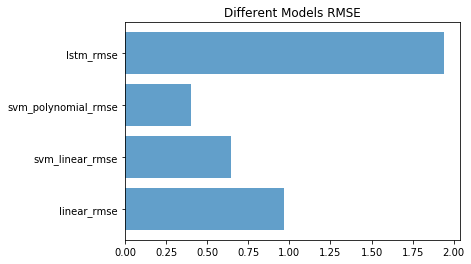

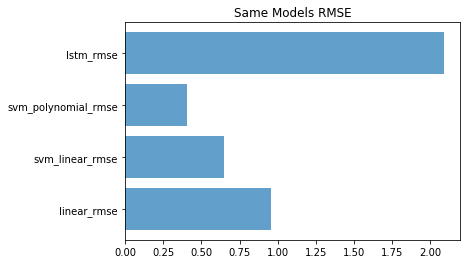

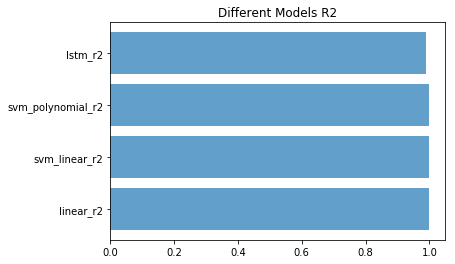

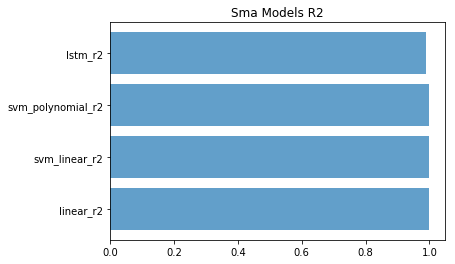

In [22]:
#plot rmse of methods
def plot_method(frame, method, title):
    #drop r2 columns
    cols = [c for c in frame.columns if method in c]
    rmse_results =frame[cols]
    plot_bar(title, rmse_results)

def plot_bar(title, dataframe):
    df = dataframe.mean(axis=0)
    objects = dataframe.columns
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, df , align='center', alpha=0.7)
    plt.yticks(y_pos, objects)
    #plt.xlabel(title)
    plt.title(title)
    plt.show()

#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40, 60))


plot_method(results_different_models, "rmse", "Different Models RMSE")
plot_method(result_same_models, "rmse", "Same Models RMSE")

plot_method(results_different_models, "r2", "Different Models R2")
plot_method(result_same_models, "r2", "Sma Models R2")